In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import planetary_computer
# import pystac_client

In [2]:
hares= pd.read_csv(os.path.join('data','knb-lter-bnz','55_Hare_Data_2012.txt'))
hares.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
0,11/26/1998,NaN,bonrip,1A,414D096A08,NaN,NaN,NaN,1370.0,160.0,NaN,917.0,51,Population
1,11/26/1998,NaN,bonrip,2C,414D320671,NaN,M,NaN,1430.0,NaN,NaN,936.0,51,Population
2,11/26/1998,NaN,bonrip,2D,414D103E3A,NaN,M,NaN,1430.0,NaN,NaN,921.0,51,Population
3,11/26/1998,NaN,bonrip,2E,414D262D43,NaN,NaN,NaN,1490.0,135.0,NaN,931.0,51,Population
4,11/26/1998,NaN,bonrip,3B,414D2B4B58,NaN,NaN,NaN,1710.0,150.0,NaN,933.0,51,Population


In [ ]:
#hares.info()

In [3]:
hares.date = pd.to_datetime(hares.date)

print(hares.age.unique())
hares.age.value_counts()

[nan 'J' 'A' 'a 1 yr.' 'a 3/4 yr.' 'a 1 yr' '1 yr' '1 yr.' '2 yrs.'
 '2 yrs' 'a 2 yrs.' '2.25 yrs' '3.5 yrs.' '3 yrs.' '2.5 yrs' '3.25 yrs.'
 'A 1.5' '?' 'U' 'j' 'a' 'u' 'J 3/4' 'A 3/4' 'A 1/2' '3/4/2013' '1/4/2013'
 '1/2/2013' '1' '1.25' '1.5']


age
A            564
J            267
a            183
j            128
1/2/2013      21
1/4/2013      21
3/4/2013      18
1             12
U             11
?             10
a 3/4 yr.      4
2 yrs.         3
u              3
A 3/4          2
1.5            2
3.5 yrs.       2
2.25 yrs       2
1 yr.          2
1 yr           2
a 1 yr.        2
3.25 yrs.      1
2.5 yrs        1
3 yrs.         1
a 2 yrs.       1
J 3/4          1
2 yrs          1
A 1/2          1
a 1 yr         1
1.25           1
A 1.5          1
Name: count, dtype: int64

In [5]:
hares.loc[hares.age.str.contains('j', case=False, na=False), 'age'] = 'juvenile'
hares.loc[hares.age.str.contains('a', case=False, na=False), 'age'] = 'adult'

hares_ja = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(hares_ja.age.unique())
hares_ja.head()

['juvenile' 'adult']


,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
108,1999-06-23,NaN,bonrip,2C,68,69,M,juvenile,395.0,126.0,NaN,643.0,53,Population
109,1999-06-23,NaN,bonrip,2E,70,71,F,juvenile,420.0,137.0,NaN,653.0,53,Population
110,1999-06-23,NaN,bonrip,3D,72,73,M,juvenile,445.0,144.0,NaN,944.0,53,Population
111,1999-06-23,NaN,bonrip,4B,76,77,M,juvenile,410.0,115.0,NaN,663.0,53,Population
112,1999-06-23,NaN,bonrip,4C,78,79,M,juvenile,430.0,132.0,NaN,670.0,53,Population


In [6]:
hares_ja['year'] = hares_ja.date.dt.year
hares_ja.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study,year
108,1999-06-23,NaN,bonrip,2C,68,69,M,juvenile,395.0,126.0,NaN,643.0,53,Population,1999
109,1999-06-23,NaN,bonrip,2E,70,71,F,juvenile,420.0,137.0,NaN,653.0,53,Population,1999
110,1999-06-23,NaN,bonrip,3D,72,73,M,juvenile,445.0,144.0,NaN,944.0,53,Population,1999
111,1999-06-23,NaN,bonrip,4B,76,77,M,juvenile,410.0,115.0,NaN,663.0,53,Population,1999
112,1999-06-23,NaN,bonrip,4C,78,79,M,juvenile,430.0,132.0,NaN,670.0,53,Population,1999


In [27]:
hares_per_year = hares_ja.groupby(['year','age']).size().reset_index(name='counts').pivot(index='year', columns='age', values='counts').reset_index()
hares_per_year.columns.name=None
hares_per_year

,year,adult,juvenile
0,1999,150.0,126.0
1,2000,159.0,67.0
2,2001,72.0,22.0
3,2002,3.0,NaN
4,2003,1.0,18.0
5,2004,NaN,8.0
6,2005,95.0,48.0
7,2006,101.0,15.0
8,2007,13.0,5.0
9,2008,84.0,57.0


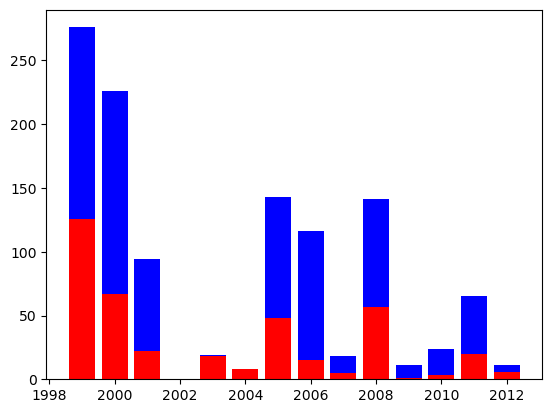

In [28]:
# # plot bars in stack manner
# plt.bar(hares_per_year['year'], hares_per_year['juvenile'], color='r')
# plt.bar(hares_per_year['year'], hares_per_year['adult'], bottom=hares_per_year['juvenile'], color='b')
# plt.show()

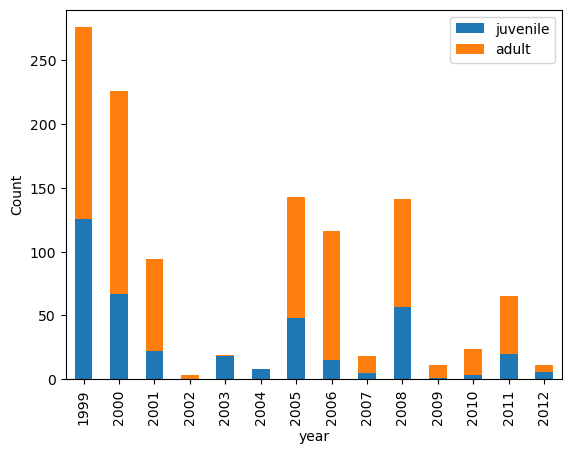

In [37]:
hares_per_year.set_index('year')[['juvenile', 'adult']].plot(
    kind='bar',
    stacked=True
)
plt.ylabel("Count")
plt.show()

In [ ]:
hares_ja['year-month'] = hares_ja.date.dt.to_period('M')
hares_ja

In [ ]:
hares_ja = hares_ja.groupby(['year-month', 'age']).size().reset_index(name='counts')
hares_ja

In [ ]:
hares_ja = hares_ja.pivot(index='year-month', columns='age', values='counts')
hares_ja

In [ ]:
hares_ja['juvenile_prop'] = hares_ja['juvenile'] / (hares_ja['juvenile']+hares_ja['adult'])

In [ ]:
fig, ax = plt.subplots()

hares_ja[hares_ja.index.month == 8].plot(ax=ax, y='juvenile_prop', marker='o', linestyle='-')
hares_ja[hares_ja.index.month == 3].plot(ax=ax, y='juvenile_prop', marker='^', linestyle='-')


In [ ]:
hares_ja = hares_ja.reset_index()
hares_ja['year'] = hares_ja['year-month'].dt.year
hares_ja['month'] = hares_ja['year-month'].dt.month
hares_ja

In [ ]:
hares_ja.plot(x='month', y='juvenile_prop', kind='scatter', c='year')

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
bbox = [-148.1734, 64.41366, -148.17303, 64.41417]
year = '1999'
month = '06'

for year in range(1999,2013):
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        search = catalog.search(
                collections=["modis-11A1-061"],
                bbox=bbox,
                datetime= f"{year}-{month}"
                )
        print(f"{year}-{month} : {len(search.item_collection())}")